## Giới thiệu
Convolutional Neural Networks (CNNs) là một nhánh trong deep neural networks, thường được dùng để giải quyết các bài toán liên quan đến dữ liệu ảnh. Các mạng CNNs với đặc điểm là các lớp tích chập (convolutional layers) để trích xuất đặc trưng từ ảnh, lớp pooling dùng để giảm kích thước ảnh nhằm tăng hiệu suất tính toán và các lớp fully-connected thực hiện phân loại dựa trên các đặc trưng đã trích xuất.

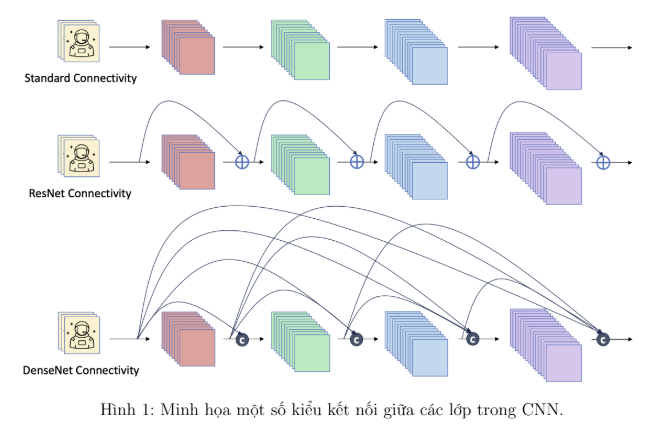

## Import các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Cố định giá trị ngẫu nhiên:
Để có thể tái tạo lại cùng một kết quả mô hình, chúng ta sẽ cố định cùng một giá trị ngẫu nhiên (seed) cho các thư viện có chứa các hàm tạo giá trị ngẫu nhiên:

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Đọc dữ liệu:
Sau khi tải và giải nén bộ dữ liệu, chúng ta sẽ được một thư mục chứa dữ liệu như sau:

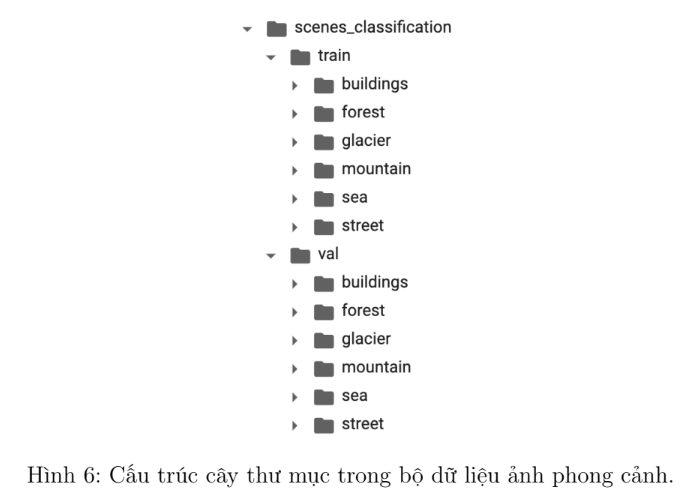

Để thuận tiện trong việc xây dựng PyTorch datasets, chúng ta sẽ ghi nhận thông tin về các classes, đường dẫn đến tất cả các ảnh cũng như label tương ứng như sau. Nhận thấy tên của các folder con trong thư mục weather-dataset/dataset cũng là tên class. Vì vậy, chúng ta sẽ đọc tên các folder này và đưa vào một dictionary như sau:

In [4]:
root_dir = '/content/drive/MyDrive/2023-AIO/AIO-MAIN/2024-module06/M06W01-07-Exercise/data/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx : class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
    }
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
           img_path = os.path.join(class_dir, img_filename)
           if 'train' in dataset_path:
             X_train.append(img_path)
             y_train.append(label_idx)
           else :
             X_test.append(img_path)
             y_test.append(label_idx)

## Chia bộ dữ liệu train, val, test:
Với danh sách đường dẫn ảnh và label, chúng ta sẽ chia thành ba bộ dữ liệu train, val, test sử dụng hàm train_test_split() của thư viện scikit-learn như sau:

In [5]:
seed = 0
val_size = 0.2
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = val_size,
    random_state=seed,
    shuffle = is_shuffle
)

## Xây dựng class pytorch datasets:
Chúng ta xây dựng class datasets cho bộ dữ liệu weather như sau:

In [6]:
class ScenesDataset(Dataset):
  def __init__(self, X, y, transform = None):
      self.transform = transform
      self.img_paths = X
      self.labels = y

  def __len__(self):
      return len(self.img_paths)

  def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      img = Image.open(img_path).convert("RGB")

      if self.transform:
           img = self.transform(img)

      return img, self.labels[idx]

## Xây dựng hàm tiền xử lý ảnh (transform):
Để đảm bảo dữ liệu ảnh đầu vào được đồng bộ về kích thước và giá trị, chúng ta tự định nghĩa hàm transform để tiền xử lý ảnh đầu vào như sau (không sử dụng thư viện **torchvision.transforms**):

Các kỹ thuật được áp dụng: resize ảnh, đổi về tensor và chuẩn hóa giá trị pixel về khoảng (0, 1).

In [7]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[... , :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0

  return normalized_img

## Khai báo datasets object cho ba bộ train, val, test:
Với class WeatherDataset và hàm chuẩn hóa ảnh, ta tạo ba object datasets tương ứng như sau:

In [8]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform = transform
)

val_dataset = ScenesDataset(
  X_val, y_val,
  transform = transform
)

test_dataset = ScenesDataset(
  X_test, y_test,
  transform = transform
)

## Khai báo dataloader:
Với ba object datasets trên, ta khai báo giá trị batch size và tạo dataloader như sau:

In [9]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
  train_dataset,
  batch_size = train_batch_size,
  shuffle = True
)
val_loader = DataLoader(
  val_dataset,
  batch_size = test_batch_size,
  shuffle = False
)
test_loader = DataLoader(
  test_dataset,
  batch_size = test_batch_size,
  shuffle = False
)

## Xây dựng model:
Trong phần này, chúng ta sẽ xây dựng class cho model deep learning với kiến trúc DenseNet. Thông tin tổng quan về kiến trúc DenseNet được thể hiện ở bảng sau:

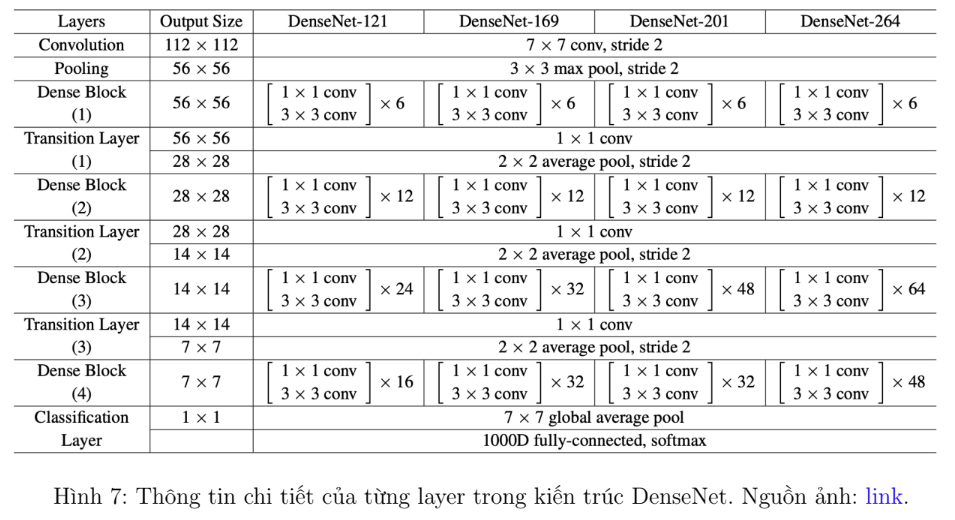

Đầu tiên, chúng ta sẽ xây dựng class **Dense Block**, có ảnh mô phỏng như hình dưới
đây:

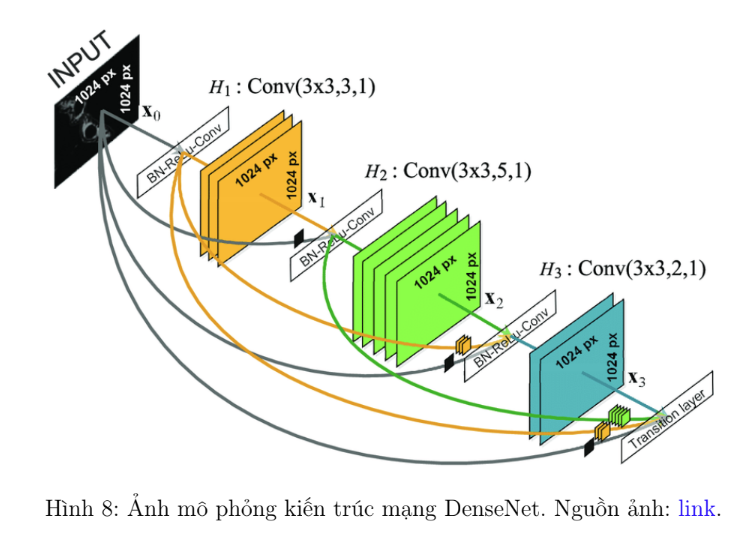

In [10]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(BottleneckBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1 , bias=False)
    self.bn2 = nn.BatchNorm2d(4 * growth_rate)
    self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias= False)
    self.relu = nn.ReLU()

  def forward(self, x):
    res = x.clone().detach()
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = torch.cat([res, x], 1)

    return x

class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate):
    super(DenseBlock, self).__init__()
    layers = []
    for i in range(num_layers):
      layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [30]:
class DenseNet(nn.Module):
  def __init__(self, num_blocks, growth_rate, num_classes):
      super(DenseNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.BatchNorm2d(2 * growth_rate)
      self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2 , padding=1)
      self.dense_blocks = nn.ModuleList()
      in_channels = 2 * growth_rate
      for i, num_layers in enumerate(num_blocks):
          self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
          in_channels += num_layers * growth_rate
          if i != len(num_blocks) - 1:
              out_channels = in_channels // 2
              self.dense_blocks.append(nn.Sequential(
                  nn.BatchNorm2d(in_channels),
                  nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                  nn.AvgPool2d(kernel_size=2, stride=2)
              ) )
              in_channels = out_channels

      self.bn2 = nn.BatchNorm2d(in_channels)
      self.pool2 = nn.AvgPool2d(kernel_size=7)
      self.relu = nn.ReLU()
      self.fc = nn.Linear(in_channels, num_classes)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.pool1(x)
      for block in self.dense_blocks:
          x = block(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.pool2(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x

In [31]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
  [6 , 12 , 24 , 16],
  growth_rate = 32,
  num_classes = n_classes
).to(device)

## Xây dựng hàm đánh giá model:
Ta xây dựng hàm đánh giá model với đầu vào là model, bộ dữ liệu đánh giá và hàm loss. Hàm này sẽ trả về giá trị loss và accuracy của model trên tập dữ liệu đầu vào:

In [32]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          losses.append(loss.item())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

## Xây dựng hàm huấn luyện model:
Ta triển khai xây dựng hàm huấn luyện mô hình như sau:

In [33]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
      batch_train_losses = []

      model.train()
      for idx, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step ()

          batch_train_losses.append(loss.item())

          train_loss = sum(batch_train_losses) / len(batch_train_losses)
      train_losses.append(train_loss)

      val_loss, val_acc = evaluate(model, val_loader, criterion, device)
      val_losses.append(val_loss)

      print(f'EPOCH {epoch + 1}:\tTrain loss : {train_loss:.4f}\tVal loss : {val_loss:.4f}')
  return train_losses, val_losses

## Khai báo hàm loss và thuật toán tối ưu hóa:
Với bài toán phân loại ảnh, ta sử dụng hàm loss CrossEntropyLoss và thuật toán tối ưu hóa Stochastic Gradient Descent (SGD). Ngoài ra, ta cũng khai báo giá trị learning rate và số epochs:

In [34]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
     model.parameters(),
     lr=lr)

## Thực hiện huấn luyện:
Với tất cả các tham số đầu vào đã sẵn sàng, ta gọi hàm *fit()* để bắt đầu quá trình huấn luyện mô hình ResNet:

In [36]:
train_losses, val_losses = fit(model,
                               train_loader,
                               val_loader,
                               criterion,
                               optimizer,
                               device,
                               epochs)

KeyboardInterrupt: 

## Đánh giá mô hình:
Ta gọi hàm *evaluate()* để đánh giá performance của model trên hai tập val và test như sau:

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device)

print('Evaluation on val / test dataset')
print('Val accuracy : ', val_acc)
print('Test accuracy : ', test_acc)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

data = np.array([[[1 , 6], [3 , 4]]])
data = torch.tensor(data, dtype = torch.float32)

bnorm = nn.BatchNorm2d(1)
data = data.unsqueeze(0)
with torch.no_grad():
  output = bnorm(data)
  print(output)

In [ ]:
import torch

a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[1, 2], [3, 4]])

a = a.reshape(1, 2, 2)
b = b.reshape(1, 2, 2)

c = torch.cat((a, b))
print(c)

In [ ]:
import torch
import torch .nn as nn

seed = 1
torch.manual_seed(seed)
input_tensor = torch.tensor([[[[1.0, 2.0], [3.0, 4.0]]]])

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
conv_output = conv_layer(input_tensor)

with torch.no_grad():
  output = conv_output + input_tensor
  print(output)